In [1]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device("cpu")

In [4]:
import scipy.integrate as integ

def normalized_hubble(z,args):
        om0 = args[1]
        omm = om0*pow(1.+z,3)
        ol0 = 1 - om0 

        return pow(omm + ol0 ,0.5)


def Ez_inv(z,args):
        return 1./normalized_hubble(z,args)


def com_dis(z,args):
        res = integ.quad(Ez_inv, 0., z, args=args)
        return res[0]


def mu_the(z,H0,om):
        mu = np.zeros(len(z))
        args = [H0,om]
        for i in range(len(z)):
                lsd = 3e5*(1+z[i])*com_dis(z[i],args)/H0
                mu[i] = 5*np.log10(lsd) + 25.
        return mu

def luminosity_distance(z,H0,om):
    dl = np.zeros(len(z))
    args = [H0,om]
    for i in range(len(z)):
        lsd = 3.e5*(1+z[i])*com_dis(z[i],args)/H0
        dl[i] = lsd
    return dl    


SN data are loaded


<ErrorbarContainer object of 3 artists>

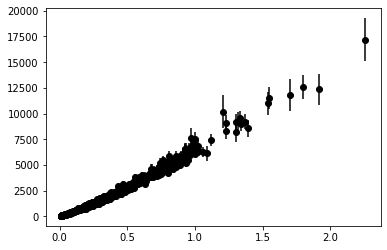

In [6]:
from pathlib import Path
import os
cwd=os.getcwd()

path_cov = cwd + '/data/cov_full.txt'
path_lcp = cwd + '/data/Tdata.txt'

cov_file = Path(path_cov)
lcp_file = Path(path_lcp)

if cov_file.is_file() and lcp_file.is_file():
    cov = np.genfromtxt(path_cov)
    lcp = np.genfromtxt(path_lcp)
                
    z_obs = lcp[:,1]
    mu_obs = lcp[:,4] + 19.3

    cov_mat_sys = np.reshape(cov,(1048,1048))
    cov_mat_sta = np.zeros((1048,1048))
    
    
    for i in range(len(lcp)):
        cov_mat_sys[i][i] = cov_mat_sys[i][i] + pow(lcp[i,5],2)
        cov_mat_sta[i][i] = cov_mat_sta[i][i] + pow(lcp[i,5],2)
        
    cov_mat_sys_inv = np.linalg.inv(cov_mat_sys)
    cov_mat_sta_inv = np.linalg.inv(cov_mat_sta)           
    print("SN data are loaded")   
    
else:
    print("SN files do not exist")
    sys.exit(0) 

dmu_obs = np.sqrt(cov_mat_sys.diagonal())
data = np.c_[z_obs,mu_obs,dmu_obs]
data.view('f8,f8,f8').sort(order=['f0'], axis=0)

z_obs = data[:,0]
mu_obs = data[:,1]
dmu_obs = data[:,2]

#dmu_obs = np.sqrt(cov_mat_sys.diagonal())

def convert_to_Dl(mu,dmu):
    dl = pow(10,(mu-25)/5)
    sig_dl = dmu*dl*0.4605
    return dl,sig_dl

  
Dl_obs , dDl_obs = convert_to_Dl(mu_obs,dmu_obs)


plt.errorbar(z_obs,Dl_obs,yerr=dDl_obs,fmt='o',lw=1,elinewidth=1.5,color="black")

In [35]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.SELU(),
    torch.nn.Linear(10,20),
    torch.nn.SELU(),
    torch.nn.Linear(20,10),
    torch.nn.SELU(),
    torch.nn.Linear(10,1),
    torch.nn.Flatten(0, 1)
)

err_y = torch.from_numpy(dDl_obs).float()
def loss_fn(y_pred,y):
    return ((y_pred - y)/err_y).pow(2).sum()

In [36]:
x = torch.from_numpy(z_obs).float()
x = torch.reshape(x,(1048,1))

#print(x.size())
y = torch.from_numpy(Dl_obs).float()

y_pred = model(x)

#x.reshape(-1,1)
#y_pred.size()
tot_par = sum([param.nelement() for param in model.parameters()])

loss = loss_fn(y_pred,y)
loss.item()

271988.40625

In [37]:
learning_rate = 1e-4
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(70000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 1000 == 1:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    #linear_layer = model[0]
    #print(linear_layer.weight)

1 271946.875
1001 264839.875
2001 251241.15625
3001 228320.515625
4001 201524.078125
5001 188085.640625
6001 186460.703125
7001 183648.046875
8001 179823.375
9001 173889.515625
10001 164070.65625
11001 150206.046875
12001 131556.546875
13001 106425.640625
14001 78311.40625
15001 49849.890625
16001 25495.5703125
17001 11351.98046875
18001 5533.3212890625
19001 3106.73779296875
20001 2191.2841796875
21001 1847.47021484375
22001 1624.80224609375
23001 1451.591552734375
24001 1306.155517578125
25001 1183.7960205078125
26001 1114.3353271484375
27001 1084.241943359375
28001 1064.362548828125
29001 1050.1304931640625
30001 1038.9012451171875
31001 1032.6593017578125
32001 1027.6463623046875
33001 1023.9454345703125
34001 1021.0263061523438
35001 1019.34130859375
36001 1018.1898193359375
37001 1017.6600341796875
38001 1016.111083984375
39001 1015.33056640625
40001 1014.9926147460938
41001 1014.607666015625
42001 1014.41650390625
43001 1014.18115234375
44001 1014.1502685546875
45001 1013.941284

tensor(-18.2933, grad_fn=<SelectBackward0>)


<ErrorbarContainer object of 3 artists>

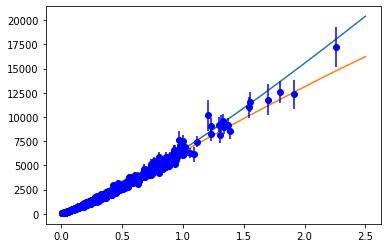

In [38]:
x_test = torch.linspace(0, 2.5, 4000, device=device, dtype=dtype)
x_test = torch.reshape(x_test,(4000,1))
y_th = luminosity_distance(x_test,70,0.3)
y_test = model(x_test)

print(y_test[0])
plt.plot(x_test,y_th)
plt.plot(x_test.detach().numpy().reshape(-1,),y_test.detach().numpy())
plt.errorbar(z_obs,Dl_obs,yerr=dDl_obs,fmt="bo")

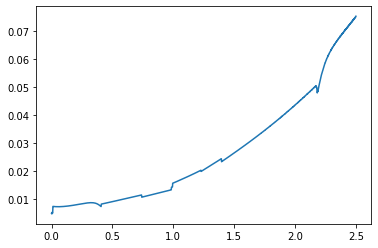

In [53]:
x_test = np.linspace(0,2.5,4000)
D_rec = y_test.detach().numpy()/(1+x_test)
#D_rec_err = y_test2[:,1]/(1+z_test)

Dp_rec = np.gradient(D_rec,x_test[1]-x_test[0])
#Dp_rec_upp = np.gradient(D_rec+D_rec_err,z_test[1]-z_test[0])
#Dp_rec_low = np.gradient(D_rec-D_rec_err,z_test[1]-z_test[0])

#plt.plot(z_test,H_t)
plt.plot(x_test,3e1/Dp_rec)
#plt.plot(z_test,3e1/Dp_rec_upp)
#plt.plot(z_test,3e1/Dp_rec_low)
#print(3e1/Dp_rec[0])